In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb

from utils import get_hash
from utils import Featurizer
from utils import plot_confusion_matrix

In [2]:
pd.set_option('display.max_colwidth', 1000)

In [3]:
# Create a featurizer object that converts a phrase into embedding vector
emb_file = os.path.join("munge", "GoogleNews-vectors-negative300.bin")
featurizer = Featurizer(emb_file)

Loading word vectors...
Done! Using 3000000 word vectors from pre-trained word2vec.


In [4]:
train = pd.read_csv(os.path.join("munge", "train.csv"))
dev = pd.read_csv(os.path.join("munge", "dev.csv"))
test = pd.read_csv(os.path.join("munge", "test.csv"))

In [5]:
landmarks = pd.read_csv(os.path.join("munge", "landmarks.txt"), sep="\t")
# Convert embeddings from string to list of floats
landmarks['embedding'] = landmarks['embedding'].apply(lambda x : list(map(float, x.split(','))))

In [6]:
def get_features(landmarks, emb):
    
    # Compute answer similarity to all landmarks
    qu_land = landmarks.copy()
    qu_land['similarity'] = qu_land['embedding'].apply(lambda x : featurizer.cossim_from_emb(emb, np.array(x)))
    qu_land['similarity'] = np.round(qu_land['similarity'], 6)
    prediction = np.array(qu_land['similarity'])
    
    return prediction

In [7]:
def kernel_matrix(data, landmarks):
    
    embeddings = data['answer'].apply(featurizer.doc2vec)
    features = np.array(list(map(lambda emb: get_features(landmarks, emb), embeddings)))
    
    return(features)

In [8]:
X_train = kernel_matrix(train, landmarks)
X_dev = kernel_matrix(dev, landmarks)
X_test = kernel_matrix(test, landmarks)

X_train[np.isnan(X_train)] = 0
X_dev[np.isnan(X_dev)] = 0
X_test[np.isnan(X_test)] = 0

y_train = np.array(train['label'])
y_dev = np.array(dev['label'])
y_test = np.array(test['label'])

In [46]:
model = LogisticRegression(random_state=0, solver='lbfgs', max_iter=30000, C=100,
                           multi_class='multinomial').fit(X_dev, y_dev)

In [68]:
model = xgb.XGBClassifier(
    objective="multi:softprob", random_state=42,
    learning_rate=0.01,
    subsample=0.7,
    max_depth=2)

model.fit(X_train, y_train, eval_set=[(X_dev, y_dev)])

[0]	validation_0-merror:0.588889
[1]	validation_0-merror:0.55
[2]	validation_0-merror:0.533333
[3]	validation_0-merror:0.527778
[4]	validation_0-merror:0.516667
[5]	validation_0-merror:0.527778
[6]	validation_0-merror:0.516667
[7]	validation_0-merror:0.511111
[8]	validation_0-merror:0.511111
[9]	validation_0-merror:0.488889
[10]	validation_0-merror:0.494444
[11]	validation_0-merror:0.494444
[12]	validation_0-merror:0.5
[13]	validation_0-merror:0.488889
[14]	validation_0-merror:0.494444
[15]	validation_0-merror:0.488889
[16]	validation_0-merror:0.494444
[17]	validation_0-merror:0.466667
[18]	validation_0-merror:0.466667
[19]	validation_0-merror:0.483333
[20]	validation_0-merror:0.477778
[21]	validation_0-merror:0.472222
[22]	validation_0-merror:0.472222
[23]	validation_0-merror:0.466667
[24]	validation_0-merror:0.472222
[25]	validation_0-merror:0.472222
[26]	validation_0-merror:0.477778
[27]	validation_0-merror:0.472222
[28]	validation_0-merror:0.466667
[29]	validation_0-merror:0.483333

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.01,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.7, verbosity=1)

# Performance Evaluation

In [69]:
model.predict(X_dev)

array([1, 0, 0, 0, 0, 3, 3, 0, 0, 1, 0, 0, 0, 1, 3, 0, 0, 3, 2, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 3, 0, 0, 3, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 3, 3, 0, 3, 0, 1, 0, 0, 0, 0, 0, 3, 0, 3, 1, 0, 0,
       3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 0, 0,
       0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 3, 1, 3, 0, 1, 0, 0, 0, 0, 3, 0, 0, 3, 0, 2, 3, 1, 0, 0, 0,
       1, 0, 3, 1])

In [70]:
labels = np.array(dev['label'])
labels

array([1, 2, 0, 0, 0, 3, 0, 1, 0, 1, 0, 0, 0, 3, 3, 0, 3, 0, 1, 3, 0, 0,
       0, 0, 3, 0, 1, 1, 1, 1, 3, 0, 0, 3, 1, 3, 1, 0, 2, 0, 1, 0, 0, 0,
       3, 3, 0, 0, 0, 0, 2, 1, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 2, 2,
       1, 1, 0, 1, 3, 2, 0, 0, 1, 1, 3, 1, 0, 3, 3, 0, 2, 0, 3, 0, 1, 0,
       1, 0, 3, 1, 1, 3, 2, 0, 3, 0, 1, 1, 1, 0, 3, 3, 3, 0, 3, 0, 3, 0,
       3, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 3, 2, 3, 1, 1, 0,
       0, 3, 2, 3, 1, 0, 3, 0, 0, 1, 0, 1, 1, 3, 1, 2, 0, 0, 1, 1, 0, 1,
       2, 0, 3, 1, 1, 0, 3, 1, 2, 0, 0, 0, 3, 2, 3, 2, 2, 0, 1, 3, 2, 0,
       1, 0, 3, 0])

## Accuracy

In [82]:
# Final accuracy
y_hat_train = model.predict(X_train)
acc = np.round(np.mean(y_train == y_hat_train),2)
print("Performance on training set")
print('Accuracy: {}'.format(acc))

Performance on training set
Accuracy: 0.64


In [83]:
# Final accuracy
y_hat_dev = model.predict(X_dev)
acc = np.round(np.mean(y_dev == y_hat_dev),2)
print("Performance on dev set")
print('Accuracy: {}'.format(acc))

Performance on dev set
Accuracy: 0.54


In [84]:
# Final accuracy
y_hat_test = model.predict(X_test)
acc = np.round(np.mean(y_test == y_hat_test),2)
print("Performance on test set")
print('Accuracy: {}'.format(acc))

Performance on test set
Accuracy: 0.42


## Confusion Matrix

Confusion matrix, without normalization
[[55  7  0 12]
 [23  8  1  6]
 [10  2  2  3]
 [28 11  1 11]]


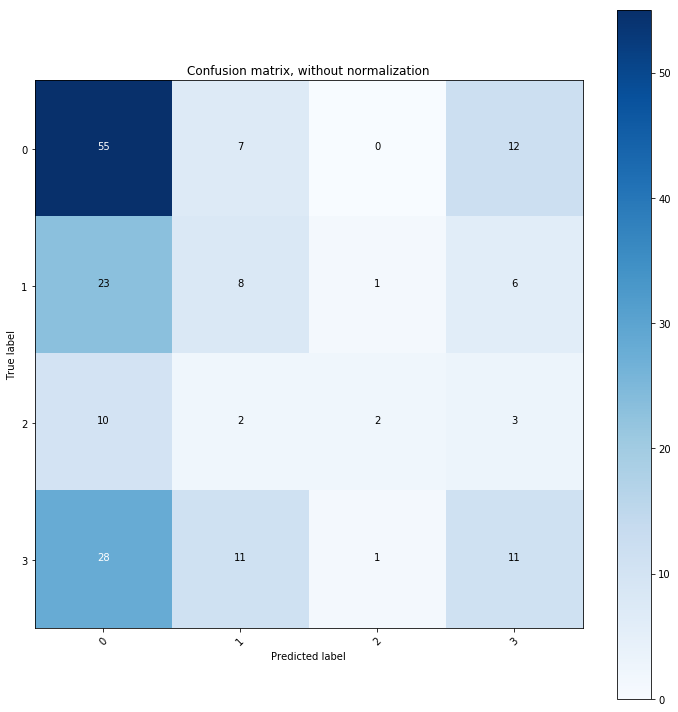

In [74]:
class_names = list(np.unique(y_test))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.Blues)

## Classification Report

In [76]:
# Compute classification report
clf_report = classification_report(y_test, y_hat_test)
print(clf_report)

              precision    recall  f1-score   support

           0       0.47      0.74      0.58        74
           1       0.29      0.21      0.24        38
           2       0.50      0.12      0.19        17
           3       0.34      0.22      0.27        51

   micro avg       0.42      0.42      0.42       180
   macro avg       0.40      0.32      0.32       180
weighted avg       0.40      0.42      0.38       180



# Error Analysis

In [123]:
dev[(dev['label']==3) & (dev['pred']==3)]

,instance_id,student_id,task_id,problem_description,question,answer,reference_answers,label,pd_hash,qu_hash,embedding,pred
14,495,DTSU021,Demo_LP01_PR01,A mover pushes a box so that it slides across a carpeted floor in a straight line at a constant speed. The push is horizontal.,Can you articulate the definition or principle that helps us determine the forces?,newtons 3rd law,"1: An object at rest will stay at rest and an object moving with constant velocity in a straight line will continue moving with constant velocity in a straight line as long as the net force acting on the object is zero. 2: When the object is in equilibrium or velocity is constant, the sum of all forces will equal 0 3: If the acceleration of a system is zero, the summation of the forces is also zero",3,b595153926,89f68d499a,"[0.07877604166666667, -0.054361979166666664, 0.15218098958333334, 0.08170572916666667, -0.14241536458333334, -0.07171630859375, -0.10123697916666667, -0.029500325520833332, 0.080810546875, 0.1151123046875, -0.06754557291666667, -0.08939615885416667, -0.13321940104166666, 0.09895833333333333, -0.16451009114583334, 0.10481770833333333, -0.038411458333333336, 0.0888671875, -0.16471354166666666, -0.15169270833333334, -0.034261067708333336, -0.07320149739583333, 0.05126953125, 0.0035502115885416665, 0.01123046875, -0.21451822916666666, -0.04476165771484375, 0.12858072916666666, -0.07975260416666667, 0.09407552083333333, -0.1328125, -0.22623697916666666, 0.13755289713541666, 0.0096435546875, -0.004496256510416667, -0.0731201171875, 0.005289713541666667, 0.2906901041666667, -0.10068766276041667, 0.11783854166666667, 0.06998697916666667, -0.04052734375, 0.10693359375, 0.09912109375, -0.00016276041666666666, 0.09326171875, 0.01568603515625, 0.017333984375, 0.014892578125, -0.002115885416666...",3
16,456,DTSU039,FM_LV04_PR05.sh,Two hockey players pass a puck between them on an ice rink. Assume that the ice is very smooth so that there is no friction.,What can you say about the net horizontal force on the puck while moving on the ice between the players?,it is balanced,"1: Since there are no forces acting on the puck in the horizontal direction, the net horizontal force is zero. 2: The net horizontal force is zero.",3,35db126042,a5c3be16a4,"[0.000885009765625, 0.0050907135009765625, 0.028157552083333332, 0.08028157552083333, -0.1220703125, -0.010416666666666666, 0.118896484375, -0.059590657552083336, 0.06591796875, -0.013468424479166666, -0.08463541666666667, -0.10392252604166667, 0.015523274739583334, 0.020182291666666668, 0.027669270833333332, 0.0899658203125, 0.012064615885416666, 0.06331380208333333, 0.009073893229166666, -0.046712239583333336, 0.023356119791666668, 0.20621744791666666, 0.053304036458333336, 0.0194091796875, 0.07918294270833333, 0.033528645833333336, -0.11214192708333333, 0.102783203125, 0.060282389322916664, 0.061604817708333336, -0.025227864583333332, 0.033854166666666664, -0.02978515625, 0.02880859375, 0.13020833333333334, 0.017985026041666668, -0.06504313151041667, 0.048065185546875, 0.10123697916666667, 0.0908203125, 0.10872395833333333, -0.01904296875, 0.018513997395833332, 0.026936848958333332, 8.138020833333333e-05, 0.10756429036458333, 0.015706380208333332, 0.06522623697916667, 0.07727050...",3
35,197,DTSU014,Demo_LP01_PR01.sh,A mover pushes a box so that it slides across a carpeted floor in a straight line at a constant speed. The push is horizontal.,What forces are acting on the box? Which forces balance each other?,The forces acting upon the box in the y direction are normal force and gravity. These two forces balance each other therefore the box does not move up or down. The forces acting upon the box in the x direction are the horizontal push from the person and friction from the carpet. These two forces do not balance each other out since the box is moving. the push force exerted by the person must be more than the frictional force in order for the box to move.,"1: The forces are the force of the mover pushing